**Data Science Bowl-2018**<br>The 2018 Data Science Bowl offers our most ambitious mission yet: create an algorithm to automate nucleus detection.

Diseases like cancer, heart disease, chronic obstructive pulmonary disease, Alzheimer’s, and diabetes. Many have seen their loved ones pass away. Think how many lives would be transformed if cures came faster.

By automating nucleus detection, you could help unlock cures faster—from rare disorders to the common cold.<br><br> 
**Problem statement**<br>To build a machine learning model that can identify a range of nuclei across varied conditions.<br><br>**Dataset**<br>https://www.kaggle.com/c/data-science-bowl-2018/data

In [0]:
# dependencies
import os
import sys
import random

import cv2
import matplotlib.pyplot as plt
from skimage.io import imshow
import tensorflow as tf
from tensorflow import keras


/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [0]:
# training data path
train_data_path = "../input/data-science-bowl-2018/stage1_train/"
image_size = 256

train_ids = next(os.walk(train_data_path))[1]

# image and mask for training dataset
x_train = np.zeros((len(train_ids),image_size, image_size, 3), dtype = np.uint8)
y_train = np.zeros((len(train_ids),image_size, image_size, 1))

for i, id_ in enumerate(train_ids):
    image_path = train_data_path+"{}/images/{}".format(id_,id_)
    img = cv2.imread(image_path+".png", 1)
    img = cv2.resize(img, (image_size, image_size))
    x_train[i] = img
    
    height, width, _ = img.shape
    label = np.zeros((height, width, 1))
    mask_path = train_data_path+"{}/masks/".format(id_)
    for mask_file in next(os.walk(mask_path))[2]:
        mask = cv2.imread(mask_path+mask_file, 0)
        mask = cv2.resize(mask, (image_size, image_size))
        mask = np.expand_dims(mask, axis=-1)
        label = np.maximum(label, mask)
    y_train[i] = label

In [0]:
# test dataset images
test_data_path = "../input/data-science-bowl-2018/stage1_test/"

test_ids = next(os.walk(test_data_path))[1]
x_test = np.zeros((len(test_ids), image_size , image_size, 3),dtype = np.uint8)

for i , id_ in enumerate(test_ids):
    test_image_path = test_data_path + "{}/images/{}".format(id_,id_)
    test_image = cv2.imread(test_image_path+".png" , 1)
    test_image = cv2.resize(test_image, (image_size, image_size))
    x_test[i] = test_image

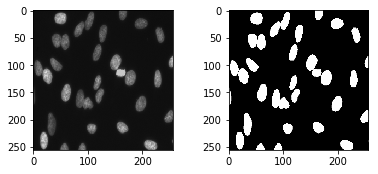

In [0]:
# image and mask visualization training dataset
rand_id = random.randint(0, len(x_train)-1)

fig = plt.figure()
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
ax = fig.add_subplot(1,2,1)
ax.imshow(x_train[rand_id])
ax = fig.add_subplot(1,2,2)
ax.imshow(np.reshape(y_train[rand_id]*255, (image_size, image_size)), cmap = 'gray')

In [0]:
# train and val split

from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(x_train, y_train, test_size = 0.2)
print (train_x.shape)
print (train_y.shape)
print (val_x.shape)
print (val_y.shape)

(536, 256, 256, 3)
(536, 256, 256, 1)
(134, 256, 256, 3)
(134, 256, 256, 1)


In [0]:
# image preprocessing and generators
from keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(rescale = 1./255,
                              rotation_range = 30,
                              height_shift_range = 0.3,
                              zoom_range = 0.3,
                              horizontal_flip = True,
                              width_shift_range = 0.3,
                              fill_mode = 'reflect')


Using TensorFlow backend.


In [0]:
# train and validation generators
seed = 42
def com_generator(gen1, gen2):
    while True:
        yield (gen1.next(), gen2.next())

train_generator_img = data_gen.flow(train_x,
                                    batch_size = 16,
                                    seed = seed,
                                    shuffle = True)
train_generator_mask = data_gen.flow(train_y,
                                     batch_size = 16,
                                     seed = seed,
                                     shuffle = True)
train_generator = com_generator(train_generator_img, train_generator_mask)

val_generator_img = data_gen.flow(val_x,
                                 batch_size = 16,
                                 seed = seed,
                                 shuffle = True)
val_generator_mask = data_gen.flow(val_y,
                                  batch_size = 16,
                                  seed = seed,
                                  shuffle = True)
val_generator = com_generator(val_generator_img, val_generator_mask)
    

In [0]:
img1, mask1 = next(train_generator)
print (img1.shape, mask1.shape)

(16, 256, 256, 3) (16, 256, 256, 1)


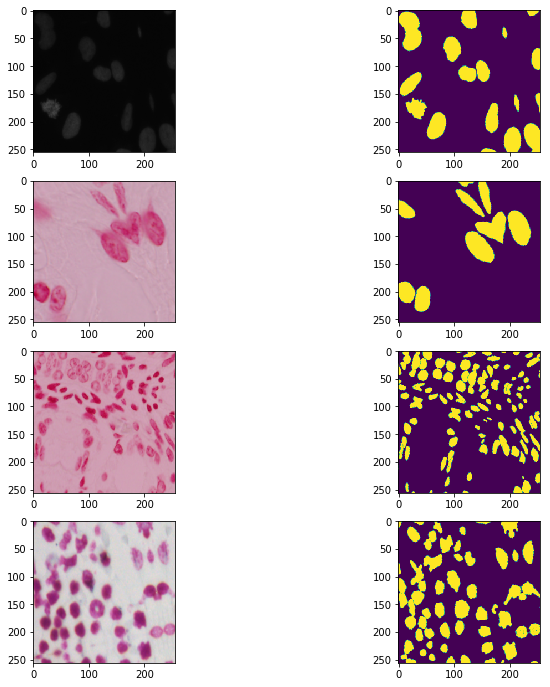

In [0]:
fig = plt.figure(figsize = (12,12))
columns = 2
rows = 4
counter = 0
c = 0
for i in range (1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    if counter%2 == 0:
        plt.imshow(img1[c])
    else:
        plt.imshow(mask1[c][:,:,0])
        c=c+1
    counter += 1
plt.show()
        

we are going to build **Deep Residual U-Net (ResUNet)** ,a semantic segmentation model to identify nuclei.<br><br>The ResUNet consists of three parts:

1.   Encoding
2.   Bridge
3.   Decoding



In encoding units, instead of using pooling operation to downsample feature map size, a stride of 2 is applied to the first convolution block to reduce the feature map by half.<br>
Before each decoding unit, there is an up-sampling of feature maps from lower level and a concatenation with the feature maps from the corresponding encoding path.<br>
At last a 1x1 Convolution is applied with Sigmoid activation to obtain a desired segmentation map.


In [0]:

def bn_act(x, act=True):
    x = keras.layers.BatchNormalization()(x)
    if act==True:
        x = keras.layers.Activation('relu')(x)
    return x

def conv_block(x, filters, kernel_size=(3,3), padding='same', strides=1):
    conv = bn_act(x)
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3,3), padding='same', strides=1):
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1,1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3,3), padding='same', strides=1):
    conv = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1,1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([shortcut, conv])
    return output

def up_sampling_concat_block(x, x_skip):
    up_sample = keras.layers.UpSampling2D((2,2))(x)
    concat = keras.layers.Concatenate()([up_sample, x_skip])
    return concat
    

In [0]:
# building a resnet model
def ResUnet():
    f = [16,32,64,128,256]
    img_=256
    inputs = keras.layers.Input((img_, img_,3))
    
    #encoding
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    
    #bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)
    
    #decoder
    u0 = up_sampling_concat_block(b1, e4)
    d0 = residual_block(u0, f[4])
    
    u1 = up_sampling_concat_block(d0, e3)
    d1 = residual_block(u1, f[3])
    
    u2 = up_sampling_concat_block(d1, e2)
    d2 = residual_block(u2, f[2])
    
    u3 = up_sampling_concat_block(d2, e1)
    d3 = residual_block(u3, f[1])
    
    output = keras.layers.Conv2D(1, (1,1), padding='same', activation='sigmoid')(d3)
    model = keras.models.Model(inputs, output)
    return model

In [0]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = tf.layers.flatten(y_true)
    y_pred_f = tf.layers.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

# loss function
def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [0]:
from tensorflow.python.keras.optimizers import adam

model = ResUnet()
model.compile(optimizer=adam(lr=0.0005), loss=dice_coef_loss, metrics=[dice_coef])
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [0]:
from tensorflow.keras.callbacks import  ModelCheckpoint
'''
callbacks=[ModelCheckpoint(monitor='val_loss',
                             filepath='dsb.h5',
                             save_best_only=True)]
                             '''
train_steps = len(train_x)//16
val_steps = len(val_x)//16
history = model.fit_generator(train_generator, steps_per_epoch = train_steps, epochs = 20,
                              validation_data = val_generator, validation_steps = val_steps )

Epoch 1/20
33/33 [==============================] - 33s 992ms/step - loss: 0.3111 - dice_coef: 0.6889 - val_loss: 0.8091 - val_dice_coef: 0.1909
Epoch 2/20
33/33 [==============================] - 14s 416ms/step - loss: 0.3290 - dice_coef: 0.6710 - val_loss: 0.7923 - val_dice_coef: 0.2077
Epoch 3/20
33/33 [==============================] - 14s 432ms/step - loss: 0.2756 - dice_coef: 0.7245 - val_loss: 0.8632 - val_dice_coef: 0.1368
Epoch 4/20
33/33 [==============================] - 14s 424ms/step - loss: 0.3466 - dice_coef: 0.6533 - val_loss: 0.7989 - val_dice_coef: 0.2011
Epoch 5/20
33/33 [==============================] - 14s 421ms/step - loss: 0.3164 - dice_coef: 0.6835 - val_loss: 0.7654 - val_dice_coef: 0.2346
Epoch 6/20
33/33 [==============================] - 14s 423ms/step - loss: 0.3102 - dice_coef: 0.6898 - val_loss: 0.8077 - val_dice_coef: 0.1923
Epoch 7/20
33/33 [==============================] - 14s 427ms/step - loss: 0.3124 - dice_coef: 0.6876 - val_loss: 0.7855 - val_dic

In [0]:
test_mask = model.predict(x_test, verbose=1)

65/65 [==============================] - 2s 30ms/sample


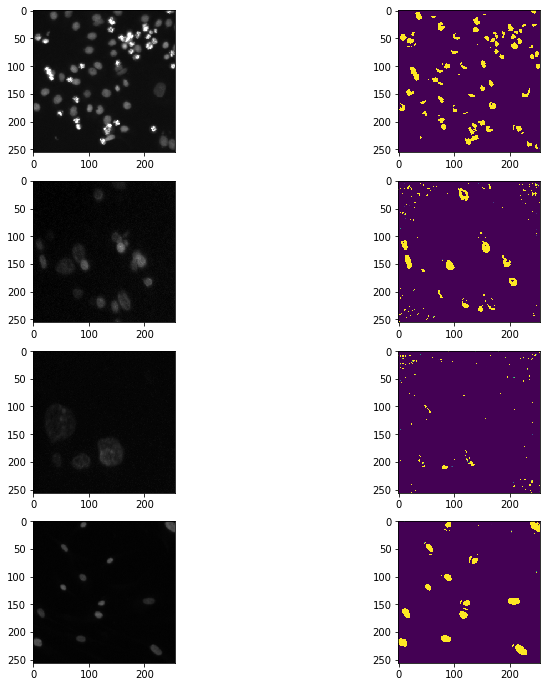

In [0]:
# visualizing test images and predicted mask(label) of those images
fig = plt.figure(figsize = (12,12))
columns = 2
rows = 4
counter = 0
c = 0
for i in range (1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    if counter%2 == 0:
        plt.imshow(x_test[c])
    else:
        plt.imshow(test_mask[c][:,:,0])
        c=c+1
    counter += 1
plt.show()